# **Machine Learning from Data**

## Lab 4: K-Nearest Neighbors and Parzen windows

2021 - Veronica Vilaplana - [GPI @ IDEAI](https://imatge.upc.edu/web/) Research group

-----------------


In [1]:
import os
import numpy as np
from numpy.linalg import pinv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KernelDensity
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, GridSearchCV
from sklearn.base import ClassifierMixin, BaseEstimator
from sklearn.utils.multiclass import unique_labels

#K-nearest neighbor classifier

The kNN classifier is a type of instance-based or non-generalizing learning, in the sense that it does not try to build a general model but simply stores training samples. Classification is done by majority voting of the nearest neighbors of each sample. A test sample is assigned to the class which has the most representatives within the k nearest neighbors of the sample.

We will use one implementation of kNN from the **scikit-learn** library (`KNeighborsClassifier`). See https://scikit-learn.org/stable/modules/neighbors.html#classification.

As all supervised estimators in scikit-learn, we need to create an instance of the class `KNeighborsClassifier`, use a  `fit(X, y)` method to fit the model and a `predict(X)` method that, given unlabeled observations X, returns the predicted labels y.

The main parameters of this function are
- n_neighbors (default = 5): number of neighbors
- weights{‘uniform’, ‘distance’} or callable, default=’uniform’: weight function used in prediction.
- algorithm{‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, default=’auto’:
algorithm used to compute the nearest neighbors

##Example [from sklearn](https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html#sphx-glr-auto-examples-neighbors-plot-classification-py): kNN using majority voting

Let's see a simple example of a kNN classifier using samples from the Iris dataset. We will use only two of the four available features per sample (Sepal Length, Sepal Width). There are three classes (Setosa, Versicolor, Virginica).
Change the number of neighbors to see the effect of this hyperparameter.

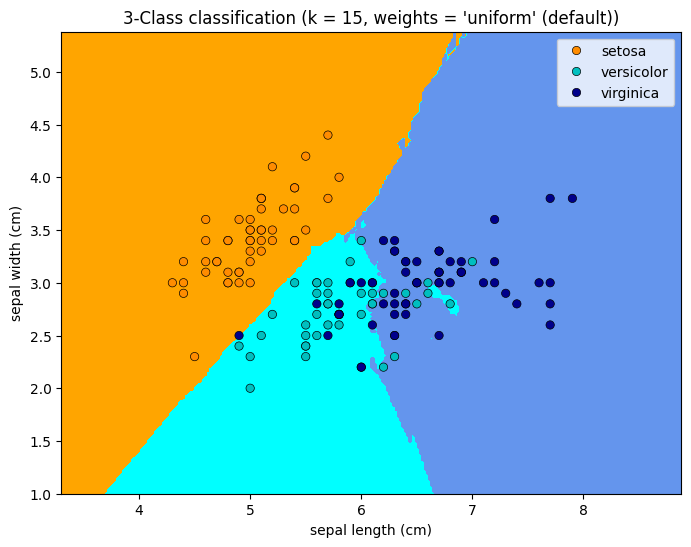

In [2]:
from matplotlib.colors import ListedColormap
from sklearn import datasets

n_neighbors = 15

# load the iris dataset
iris = datasets.load_iris()

# we only take the first two features. We could avoid this slicing by using a two-dim dataset
X = iris.data[:, :2]
y = iris.target

h = 0.02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(["orange", "cyan", "cornflowerblue"])
cmap_bold = ["darkorange", "c", "darkblue"]

# we create an instance of Neighbours Classifier and fit the data.
clf = KNeighborsClassifier(n_neighbors)
clf.fit(X, y)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
sns.scatterplot(
    x=X[:, 0],
    y=X[:, 1],
    hue=iris.target_names[y],
    palette=cmap_bold,
    alpha=1.0,
    edgecolor="black",
)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("3-Class classification (k = %i, weights = 'uniform' (default))" % (n_neighbors))
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])

plt.show()

##Example [from sklearn](https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html#sphx-glr-auto-examples-neighbors-plot-classification-py): kNN using distance-based weights

The basic nearest neighbors classification uses uniform weights: that is, the value assigned to a query point is computed from a simple majority vote of the nearest neighbors. Under some circumstances, it is better to weight the neighbors such that nearer neighbors contribute more to the fit. This can be accomplished through the weights keyword. The default value, weights = 'uniform', assigns uniform weights to each neighbor. weights = 'distance' assigns weights proportional to the inverse of the distance from the query point. Alternatively, a user-defined function of the distance can be supplied to compute the weights.

Let's see the second case on the iris dataset:

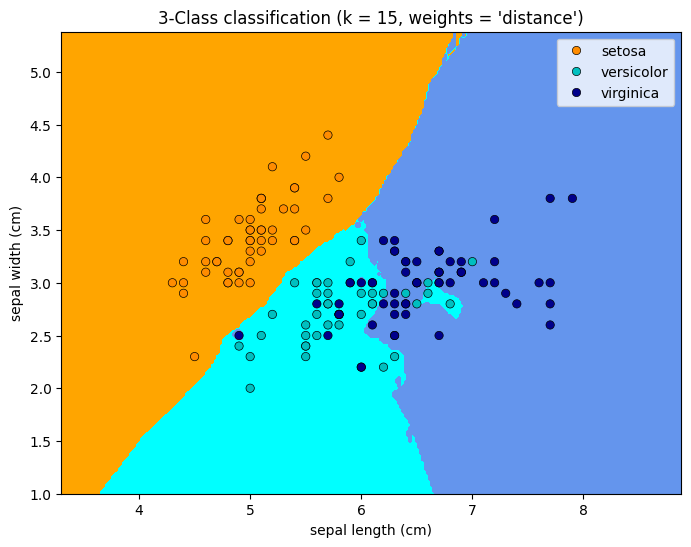

In [3]:

# we create an instance of Neighbours Classifier and fit the data.
clf = KNeighborsClassifier(n_neighbors, weights= 'distance')
clf.fit(X, y)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
sns.scatterplot(
    x=X[:, 0],
    y=X[:, 1],
    hue=iris.target_names[y],
    palette=cmap_bold,
    alpha=1.0,
    edgecolor="black",
)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("3-Class classification (k = %i, weights = 'distance')" % (n_neighbors))
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])

plt.show()

# Classification of the Zip dataset

## Data loading

The Zip code is a dataset of handwritten digits, scanned from envelopes by the U.S. Postal Service. The images have been deslanted and sized normalized. Each element is a vector of d=256 features corresponding to intensity values of a 16x16 image of a handwritten digit. Images are vectorized row by row. There are 10 classes (digits 0 to 9). The dataset is already split into training and test subsets.

The training and testing splits are on separate files and consist on text files with a line for each sample, each line has the label and the pixel values separated by spaces.

Load the files `zip_train` and `zip_test`.

In [4]:
TRAIN_DATA_FILENAME = "zip_train"
TEST_DATA_FILENAME = "zip_test"

We can define a utility function to load the data from the text files and return the images and labels as separate [NumPy ndarrays](https://numpy.org/doc/stable/reference/arrays.ndarray.html).

In [5]:
def load_dataset_as_ndarray(filename, reshape=False):
    """Return images and labels form filename as NumPy arrays.

    If reshape is True, reshape samples to 16x16.
    """
    data = np.loadtxt(filename)
    X = data[:, 1:]
    y = data[:, 0]
    if reshape:
        X = X.reshape((-1, 16, 16))
    return X, y

In [6]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/MLEARN_Labs/Lab4/")

Mounted at /content/drive


In [7]:
# Load the training split.
X_train, y_train = load_dataset_as_ndarray(TRAIN_DATA_FILENAME)
# Load the test split.
X_test, y_test = load_dataset_as_ndarray(TEST_DATA_FILENAME)
print(X_train.shape)
print(X_test.shape)

(7291, 256)
(2007, 256)


## Training a k-NN classifier
Wel will train a dimensionality reduction technique for feature selection and a k-nearst neighbour classifer.

First, we set all the variables defining the experiment to be performed: with or without feature selection (`reduction`), technique to use PCA or MDA (`dim_reducer`) and number of features (`n_components`)

In [51]:
reduction = int(input("Choose reduction type.\nNo reduction (0), PCA (1), MDA(2): "))
if reduction > 0:
    n_components = int(input("Choose dimenstionality: "))
    if reduction == 1:
        dim_reducer = PCA(n_components=n_components)
    elif reduction == 2:
        dim_reducer = LinearDiscriminantAnalysis(n_components=n_components)
    else:
        dim_reducer = None
elif reduction == 0:
    dim_reducer = "passthrough"
else:
    dim_reducer = None

if not dim_reducer:
    print("Please choose one of the valid options (run this cell again).")

Choose reduction type.
No reduction (0), PCA (1), MDA(2): 2
Choose dimenstionality: 9


##Pipelines

Scikit-learn provides a `Pipeline` utility to help automate machine learning workflows. Pipelines work by allowing for a linear sequence of data transforms to be chained together culminating in a modeling process that can be evaluated.

A [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

**Convenience and encapsulation**
You only have to call fit and predict once on your data to fit a whole sequence of estimators.

**Joint parameter selection**
You can grid search over parameters of all estimators in the pipeline at once.

**Safety**
Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

All estimators in a pipeline, except the last one, must be transformers (i.e. must have a transform method). The last estimator may be any type (transformer, classifier, etc.).


In this case we define a pipeline that
1. Standardizes features by removing the mean
2. Reduces dimensionality and
3. Applies a kNN classifier:



In [52]:
model = Pipeline([
    ('center', StandardScaler(with_mean=True, with_std=False)),
    ('reduce_dim', dim_reducer),
    ('clf', KNeighborsClassifier())
])

Fit all the transformers one after the other and transform the data. Finally, fit the transformed data using the final estimator.

In [53]:
model.fit(X_train, y_train)

Pipeline(steps=[('center', StandardScaler(with_std=False)),
                ('reduce_dim', LinearDiscriminantAnalysis(n_components=9)),
                ('clf', KNeighborsClassifier())])

To check the number of neighbors we need to acces the "clf" step from the pipeline and then access its `n_neighbors` attribute:

In [54]:
print("Number of neighbors (k):", model["clf"].n_neighbors)

Number of neighbors (k): 5


Transform the data, and apply `predict` with the final estimator:

A `model.predict` call applies a `transform` to each transformer in the pipeline. The transformed data are finally passed to the final estimator that calls `predict` method. This is only valid if the final estimator implements a `predict` method.

In [55]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

We can now compute and plot the classification report with precision, recall, f-score per class and global accuracy

In [56]:
print("TRAINING\n" + classification_report(y_train, pred_train))
print("\nTESTING\n" + classification_report(y_test, pred_test))

TRAINING
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      1194
         1.0       0.99      1.00      0.99      1005
         2.0       0.96      0.96      0.96       731
         3.0       0.96      0.96      0.96       658
         4.0       0.94      0.96      0.95       652
         5.0       0.95      0.95      0.95       556
         6.0       0.97      0.98      0.98       664
         7.0       0.96      0.97      0.96       645
         8.0       0.96      0.92      0.94       542
         9.0       0.96      0.95      0.96       644

    accuracy                           0.97      7291
   macro avg       0.96      0.96      0.96      7291
weighted avg       0.97      0.97      0.97      7291


TESTING
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.95       359
         1.0       0.98      0.95      0.97       264
         2.0       0.89      0.89      0.89       198
      

We can also compute the training and test error and confusion matrices

In [57]:
train_error = 1. - accuracy_score(y_train, pred_train)
train_cmat = confusion_matrix(y_train, pred_train)
test_error = 1. - accuracy_score(y_test, pred_test)
test_cmat = confusion_matrix(y_test, pred_test)

print('train error: %f ' % train_error)
print('train confusion matrix:')
print(train_cmat)
print('test error: %f ' % test_error)
print('test confusion matrix:')
print(test_cmat)

train error: 0.033603 
train confusion matrix:
[[1183    0    4    0    0    1    4    0    2    0]
 [   0 1000    0    0    1    0    2    0    1    1]
 [   4    2  700    5    8    0    2    3    7    0]
 [   1    0    5  631    0   12    0    2    7    0]
 [   1    5    8    0  624    1    4    0    0    9]
 [   6    0    3    9    6  526    1    0    3    2]
 [   5    2    3    0    1    3  649    0    1    0]
 [   0    1    0    2    5    1    0  624    2   10]
 [   5    2    5   12    7    7    4    2  497    1]
 [   1    0    1    1   11    0    0   18    0  612]]
test error: 0.094669 
test confusion matrix:
[[348   0   2   1   3   0   3   1   1   0]
 [  0 251   1   2   3   0   5   1   0   1]
 [  5   0 176   4   4   1   2   1   5   0]
 [  3   0   5 138   1  10   0   1   7   1]
 [  2   1   6   0 183   1   1   2   0   4]
 [  4   0   0  12   3 136   0   0   2   3]
 [  4   0   4   0   3   3 155   0   1   0]
 [  0   0   0   2   6   0   0 134   1   4]
 [  5   1   3   8   6   5   2   0

We can visualize the confusion matrix with `ConfusionMatrixDisplay`. See details [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay)

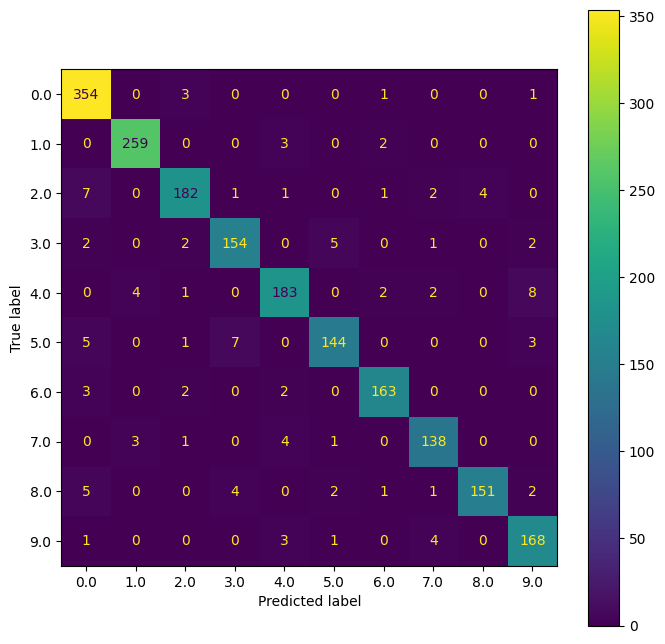

In [17]:
display = ConfusionMatrixDisplay(confusion_matrix=test_cmat,display_labels=model["clf"].classes_)
fig, ax = plt.subplots(figsize=(8,8))
display.plot(ax=ax, values_format='')
plt.show()

### Plotting "eigen-images" (only for dimensionality reduction)

In [18]:
if reduction > 0:
    if reduction == 1:
        components = model["reduce_dim"].components_.reshape((n_components, 16, 16))
    else:
        components = model["reduce_dim"].scalings_.T.reshape((n_components, 16, 16))

    plt.figure(figsize=(1.8 * 2, 2.4 * 5))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(min(n_components, 10)):
        plt.subplot(5, 2, i + 1)
        plt.imshow(components[i].reshape((16, 16)), cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())

### Plotting reconstructed images

In [19]:
def plot_reconstructed_image(sample):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(sample.reshape((16, 16)), cmap=plt.cm.gray)
    ax1.set_title("Original")
    sample_transformed = model[:2].transform(sample.reshape(1, -1))
    if reduction > 0:
        if reduction == 1:
            sample_reconstructed = model[1].inverse_transform(sample_transformed)
        else:
            sample_reconstructed = np.dot(sample_transformed, pinv(model["reduce_dim"].scalings_))
    else:
        sample_transformed = sample
    ax2.imshow(sample_reconstructed.reshape((16, 16)), cmap=plt.cm.gray)
    ax2.set_title("Reconstructed")

Try the function using different samples.

In [20]:
if reduction > 0:
  plot_reconstructed_image(X_train[10])

## Finding the best 'k' in kNN

When evaluating different hyperparameters for estimators, such as the 'k' in kNN, we can't just train the model on the training set for different values of 'k', and evaluate them on the test set. There is a risk of overfitting on the test set because the parameters can be tweaked until the estimator performs optimally. This way, knowledge about the test set can “leak” into the model and evaluation metrics no longer report on generalization performance. To solve this problem, yet another part of the dataset can be held out as a so-called “validation set”: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set.

However, by partitioning the available data into three sets (training, validation and test), we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.

In the following lab we will see different **cross-validation strategies** for dealing with this problem.

In this lab we will use the simplest strategy, using a fixed single partition into train, validation and test subsets. We will train the model for different values of 'k' on the training set, and select the value of 'k' that achieves the best performance on the validation set.



We will use an approach named GridSearchCV, combined with the use of Pipelines (since we need to perform feature scaling and dimensionality reduction before training the model)

### Using [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

Two generic approaches to parameter search are provided in scikit-learn: for given values, `GridSearchCV` exhaustively considers all parameter combinations, while `RandomizedSearchCV` can sample a given number of candidates from a parameter space with a specified distribution.

The grid search provided by GridSearchCV exhaustively generates candidates from a grid of parameter values specified with the param_grid parameter. The GridSearchCV instance implements the usual estimator API: when “fitting” it on a dataset, all the possible combinations of parameter values are evaluated and the best combination is retained. A GridSeachCV object internally iterates over a parameter grid and computes cross-validated scores for each hyper-parameter set.

In this case we are only validating one hyper-parameter (`n_neighbors`), but we could validate multiple parameters from any step of our pipeline.


Next we create a GridSearchCV object. It has several parameters:

* The `estimator` parameter, thas is the model we are using (in this case "model")

* The `param_grid` parameter requires a list of parameters and the range of values for each parameter of the specified estimator. A list of values to choose from should be given to each hyperparameter of the model

* A cross validation process `cv` that is performed in order to determine the hyperparameter value set which provides the best accuracy levels.

Here, as we mentioned before, we will use a single split of the training data into training and validation sets, so  the `cv` will be `StratifiedShuffleSplit` with a single split. The training subset will contain 75% of the training data. StratifiedShuffleSplit  returns stratified splits, i.e creates splits by preserving the same percentage for each target class as in the complete set.

For each value of the hyperparameter (or each combination of hyperparameters if there are more than one), the model will be trained on the training subset. It will return the best set of hyperparameters (evaluated on the validation set), and the model trained on these parameters.

To understand the parameter grid syntax for pipelines, see [here](https://scikit-learn.org/stable/modules/compose.html#nested-parameters).

We will define a new pipeline, `model2`. Previously, you can choose the reduction type (no reduction, PCA, MDA)



In [21]:
reduction = int(input("Choose reduction type.\nNo reduction (0), PCA (1), MDA(2): "))
if reduction > 0:
    n_components = int(input("Choose dimenstionality: "))
    if reduction == 1:
        dim_reducer = PCA(n_components=n_components)
    elif reduction == 2:
        dim_reducer = LinearDiscriminantAnalysis(n_components=n_components)
    else:
        dim_reducer = None
elif reduction == 0:
    dim_reducer = "passthrough"
else:
    dim_reducer = None

if not dim_reducer:
    print("Please choose one of the valid options (run this cell again).")

Choose reduction type.
No reduction (0), PCA (1), MDA(2): 0


In [23]:
model2 = Pipeline([
    ('center', StandardScaler(with_mean=True, with_std=False)),
    ('reduce_dim', dim_reducer),
    ('clf', KNeighborsClassifier())
])

In [24]:
# Here you can put the values of "k" to try.

Ks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [25]:
grid_search_cv = GridSearchCV(estimator = model2,
                              param_grid={"clf__n_neighbors": Ks},
                              cv=StratifiedShuffleSplit(n_splits=1, train_size=0.75,random_state=1), return_train_score=True)
grid_search_cv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=1, random_state=1, test_size=None,
            train_size=0.75),
             estimator=Pipeline(steps=[('center',
                                        StandardScaler(with_std=False)),
                                       ('reduce_dim', 'passthrough'),
                                       ('clf', KNeighborsClassifier())]),
             param_grid={'clf__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             return_train_score=True)

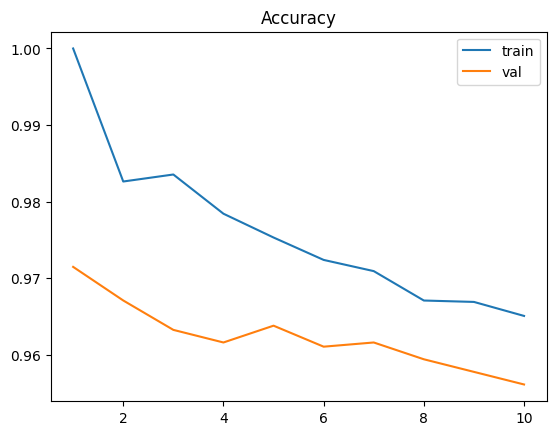

In [26]:
plt.plot(grid_search_cv.cv_results_["param_clf__n_neighbors"].data, grid_search_cv.cv_results_["mean_train_score"], label="train")
plt.plot(grid_search_cv.cv_results_["param_clf__n_neighbors"].data, grid_search_cv.cv_results_["mean_test_score"], label="val")
plt.legend()
plt.title("Accuracy");

We can see the parameter setting that gave the best results on the hold out data(`best_params_`):



In [27]:
print(grid_search_cv.best_params_)

{'clf__n_neighbors': 1}


Calling `predict` on a fitted GridSearchCV object will make predictions using **the best set of hyper-parameters**.

In [28]:
pred_test = grid_search_cv.predict(X_test)

test_error = 1. - accuracy_score(y_test, pred_test)
test_cmat = confusion_matrix(y_test, pred_test)

print('test error: %f ' % test_error)
print('test confusion matrix:')
print(test_cmat)

test error: 0.056303 
test confusion matrix:
[[355   0   2   0   0   0   0   1   0   1]
 [  0 255   0   0   6   0   2   1   0   0]
 [  6   1 183   2   1   0   0   2   3   0]
 [  3   0   2 154   0   5   0   0   0   2]
 [  0   3   1   0 182   1   2   2   1   8]
 [  2   1   2   4   0 145   2   0   3   1]
 [  0   0   1   0   2   3 164   0   0   0]
 [  0   1   1   1   4   0   0 139   0   1]
 [  5   0   1   6   1   1   0   1 148   3]
 [  0   0   1   0   2   0   0   4   1 169]]


## Parzen windows with cross validation
Scikit-learn does not provide a classifer class for the Parzen windows method. We will implement it ourselves following the predictor interface by means of the `KernelDensity` class.


In [29]:
class ParzenClassifier(BaseEstimator, ClassifierMixin):
    densities = {}  # Dictionary containing density estimation for each class.

    def __init__(self, bandwidth=1.0, kernel="gaussian"):
        self.bandwidth = bandwidth
        self.kernel = kernel

    def fit(self, X, y):
        self.classes_ = unique_labels(y)
        # Fit kernel density estimator (Parzen windows) for each class.
        for c in self.classes_:
            n = (y_train == c).sum()
            hn = self.bandwidth / np.sqrt(n)
            self.densities[c] = KernelDensity(bandwidth=hn, kernel=self.kernel).fit(X[y == c])
        return self

    def predict(self, X):
        y_pred = np.empty(X.shape[0])
        for idx, x in enumerate(X):
            # Estimate log-probability of sample for each class.
            log_probs = {c: self.densities[c].score_samples(x.reshape(1, -1))
                         for c in self.classes_}
            y_pred[idx] = max(log_probs, key=log_probs.get)

        return y_pred

Use the previous class (`ParzenClassifier`) and add the necesary code to
1. Create a pipeline `model_parzen` for the Parzen classifier, which (1)
standardizes data using `StandardScaler`, (2) reduces dimensionality and (3) applies the Parzen classifier.
2. Perform hyperparmeter search using `GridSearchCV` for the windows' bandwith h, using a single shuffled stratified random split.
4. Plot the mean score on the train and validation folds for each value of the hyperparameter
3. Using the best model, compute and display the test error and confusion matrix

In [30]:
reduction = int(input("Choose reduction type.\nNo reduction (0), PCA (1), MDA(2): "))
if reduction > 0:
    n_components = int(input("Choose dimenstionality: "))
    if reduction == 1:
        dim_reducer = PCA(n_components=n_components)
    elif reduction == 2:
        dim_reducer = LinearDiscriminantAnalysis(n_components=n_components)
    else:
        dim_reducer = None
elif reduction == 0:
    dim_reducer = "passthrough"
else:
    dim_reducer = None

if not dim_reducer:
    print("Please choose one of the valid options (run this cell again).")

Choose reduction type.
No reduction (0), PCA (1), MDA(2): 0


In [31]:
model_parzen = Pipeline([
    ('center', StandardScaler(with_mean=True, with_std=False)),
    ('reduce_dim', dim_reducer),
    ('clf', ParzenClassifier())
])

In [35]:
# Here you can put the values of "h" to try.
#Hs = [1, 10, 20, 30, 40, 50, 60, 70]
#Hs = np.logspace(-2, 2, 10)  # 10 values from 0.01 to 100
Hs = [10, 20, 25, 30, 33, 35, 37, 40, 50]

In [36]:
# Hyperparameter search using GridSearchCV
grid_search_cv_parzen = GridSearchCV(estimator=model_parzen,
                                     param_grid={"clf__bandwidth": Hs},
                                     cv=StratifiedShuffleSplit(n_splits=1, train_size=0.75, random_state=1),
                                     return_train_score=True)
grid_search_cv_parzen.fit(X_train, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=1, random_state=1, test_size=None,
            train_size=0.75),
             estimator=Pipeline(steps=[('center',
                                        StandardScaler(with_std=False)),
                                       ('reduce_dim', 'passthrough'),
                                       ('clf', ParzenClassifier())]),
             param_grid={'clf__bandwidth': [10, 20, 25, 30, 33, 35, 37, 40,
                                            50]},
             return_train_score=True)

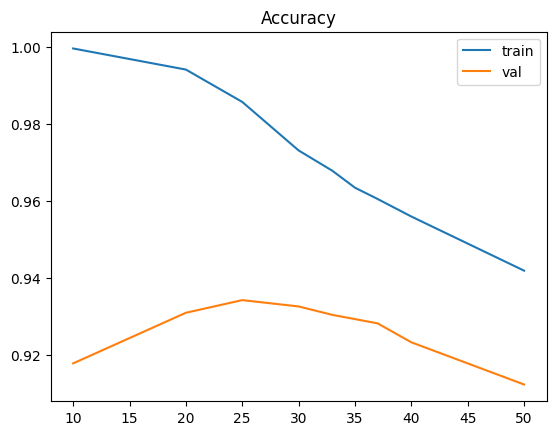

In [ ]:
plt.plot(grid_search_cv_parzen.cv_results_["param_clf__bandwidth"].data, grid_search_cv_parzen.cv_results_["mean_train_score"], label="train")
plt.plot(grid_search_cv_parzen.cv_results_["param_clf__bandwidth"].data, grid_search_cv_parzen.cv_results_["mean_test_score"], label="val")
plt.legend()
plt.title("Accuracy");

In [ ]:
print("Best parameters: ", grid_search_cv_parzen.best_params_)

Best parameters:  {'clf__bandwidth': 25}


In [ ]:
pred_test_parzen = grid_search_cv_parzen.predict(X_test)

In [ ]:
test_error_parzen = 1. - accuracy_score(y_test, pred_test_parzen)
test_cmat_parzen = confusion_matrix(y_test, pred_test_parzen)

In [ ]:
print('Test error: %f ' % test_error_parzen)
print('Test confusion matrix:')
print(test_cmat_parzen)

Test error: 0.094669 
Test confusion matrix:
[[343   0   1   3   2   3   5   0   1   1]
 [  0 250   0   1   4   0   6   0   0   3]
 [  4   0 175   4   4   2   1   1   7   0]
 [  1   0   4 140   1  11   0   2   6   1]
 [  0   1   6   0 177   1   2   2   1  10]
 [  3   0   0  13   1 136   0   0   3   4]
 [  2   0   3   0   2   3 159   0   1   0]
 [  0   0   0   2   6   0   0 132   1   6]
 [  3   1   2   7   4   3   1   0 141   4]
 [  0   1   0   0   5   0   0   5   2 164]]


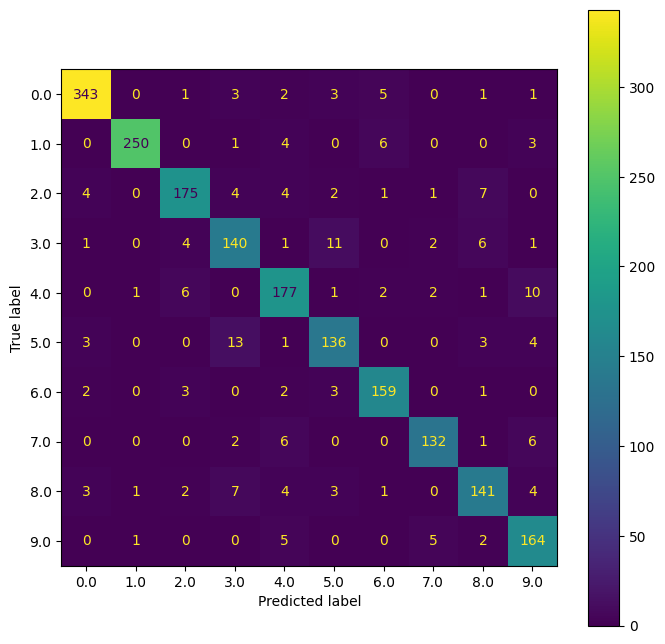

In [ ]:
display = ConfusionMatrixDisplay(confusion_matrix=test_cmat_parzen,
                                        display_labels=grid_search_cv_parzen.best_estimator_["clf"].classes_)
fig, ax = plt.subplots(figsize=(8,8))
display.plot(ax=ax, values_format='')
plt.show()